In [1]:
import os
os.chdir('..')

In [2]:
from itertools import chain

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from tqdm.notebook import tqdm
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree, metrics
from xgboost import XGBClassifier

In [25]:
import shap
import xgboost
shap.initjs()

In [4]:
from espora import fragmenter

In [5]:
def get_mw(smi):
    mol = Chem.MolFromSmiles(smi)
    return Descriptors.MolWt(mol)

In [6]:
def run_fragrank_frag(smis, threhsold_mw=250):
    fragments = [fragmenter.frag_rec(smi) for smi in tqdm(smis, desc="Fragmenting")]
    fragments = [list(filter(lambda x: get_mw(x) < threhsold_mw, fragment)) for fragment in fragments]
    
    unique_subs = set()
    for subs in chain.from_iterable(fragments):
        unique_subs.add(subs)

    G = nx.Graph()
    for sub in unique_subs:
        G.add_node(sub)

    for i in range(len(smis)):
        for j in range(len(fragments[i])):
            for k in range(j+1, len(fragments[i])):
                sub1 = fragments[i][j]
                sub2 = fragments[i][k]
                if G.has_edge(sub1, sub2):
                    G[sub1][sub2]['weight'] += 1
                else:
                    G.add_edge(sub1, sub2, weight=1)

    pr = nx.pagerank(G)
    return pr

In [7]:
def featurize(smis, top_fragments_mols):
    X_vec = []
    for smi in tqdm(smis, desc="Featurizing"):
        mol = Chem.MolFromSmiles(smi)
        X_vec.append(np.array([mol.HasSubstructMatch(i) for i in top_fragments_mols]).astype(int))
    return np.array(X_vec) 

In [8]:
def model(clf, X_train, X_test, y_train, y_test, top_fragments_mols):
    X_train = featurize(X_train, top_fragments_mols)
    X_test = featurize(X_test, top_fragments_mols)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("recall_score: ", metrics.recall_score(y_test, y_pred))
    print("precision_score: ", metrics.precision_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    return (metrics.recall_score(y_test, y_pred), metrics.precision_score(y_test, y_pred))

In [9]:
df = pd.read_csv("./data/Q16602.csv")
# df = pd.read_csv("./data/O14649.csv")
# df = pd.read_csv("./data/P04629.csv")
# df = pd.read_csv("./data/A5PKW4.csv")

In [10]:
df["mw"] = df["canonical_smiles"].apply(lambda x: get_mw(x))

In [11]:
df = df[df["mw"] < 800]

In [12]:
df[df['100 uM'] == 1.0]

,source,id,canonical_smiles,pchembl_value,100 uM,10 uM,1 uM,0.1 uM,augmentation,mw
0,chembl,CHEMBL1088906,CN1C(=O)NC(=O)[C@@]12Cc1cc3nc(Cn4c(=O)n(-c5ccc...,5.22,1.0,1.0,0.0,0.0,NaN,480.484
1,chembl,CHEMBL1089207,CN1C(=O)NC(=O)C12Cc1cc3ncc(Cn4c(=O)n(-c5ccccn5...,6.73,1.0,1.0,1.0,0.0,NaN,491.511
2,chembl,CHEMBL1089433,CC12CC(=O)Nc3cccc(c31)N(Cc1ccc3cc4c(cc3n1)C[C@...,8.89,1.0,1.0,1.0,1.0,NaN,487.563
3,chembl,CHEMBL1089496,CN1C(=O)NC(=O)[C@]12Cc1cc(F)c(NC(=O)Cn3c(=O)n(...,6.14,1.0,1.0,1.0,0.0,NaN,500.490
4,chembl,CHEMBL1089497,CN1C(=O)NC(=O)[C@@]12Cc1cc3nc(Cn4c(=O)n(-c5ccc...,5.18,1.0,1.0,0.0,0.0,NaN,479.500
...,...,...,...,...,...,...,...,...,...,...
748,chembl,CHEMBL87174,CCC1CN2CCC1CC2[C@H](O)c1cc(-c2cccc3ccccc23)nc2...,4.48,1.0,0.0,0.0,0.0,NaN,452.598
749,chembl,CHEMBL88111,CCC1CN2CCC1CC2[C@H](O)c1cc(-c2ccc3c(c2)OCO3)nc...,4.13,1.0,0.0,0.0,0.0,NaN,446.547
750,chembl,CHEMBL88441,CCC1CN2CCC1CC2[C@H](O)c1cc(-c2ccc(Oc3ccccc3)cc...,4.92,1.0,0.0,0.0,0.0,NaN,494.635
751,chembl,CHEMBL88582,CCC1CN2CCC1CC2[C@H](O)c1cc(-c2ccc(Cl)cc2Cl)nc2...,4.43,1.0,0.0,0.0,0.0,NaN,471.428


In [13]:
X = df.canonical_smiles.values
y = df["100 uM"].values

In [14]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=42)

In [15]:
sss.get_n_splits(X, y)

1

In [24]:
top_k = 750
for i, (train_index, test_index) in enumerate(sss.split(X, y)):
    print(f"Fold {i+1}/{sss.get_n_splits(X, y)}: Top K: {top_k}")
    clf = XGBClassifier()
    pr = run_fragrank_frag(X[train_index][y[train_index] == 1.0])
    precs = []
    recalls = []
    top_fragments = sorted(pr, key=pr.get, reverse=True)[:top_k]
    top_fragments_mols = [Chem.MolFromSmarts(i) for i in top_fragments]
    r,p = model(clf, X[train_index], X[test_index], y[train_index], y[test_index], top_fragments_mols)
    precs.append(p)        
    recalls.append(r)

Fold 1/1: Top K: 750


Fragmenting:   0%|          | 0/494 [00:00<?, ?it/s]

Featurizing:   0%|          | 0/1997 [00:00<?, ?it/s]

Featurizing:   0%|          | 0/984 [00:00<?, ?it/s]

recall_score:  0.9918032786885246
precision_score:  0.979757085020243
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       740
         1.0       0.98      0.99      0.99       244

    accuracy                           0.99       984
   macro avg       0.99      0.99      0.99       984
weighted avg       0.99      0.99      0.99       984



In [32]:
model = XGBClassifier()
X_train = featurize(X[train_index], top_fragments_mols)
X_test = featurize(X[test_index], top_fragments_mols)
model.fit(X_train, y[train_index])

Featurizing:   0%|          | 0/1997 [00:00<?, ?it/s]

Featurizing:   0%|          | 0/984 [00:00<?, ?it/s]

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [33]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


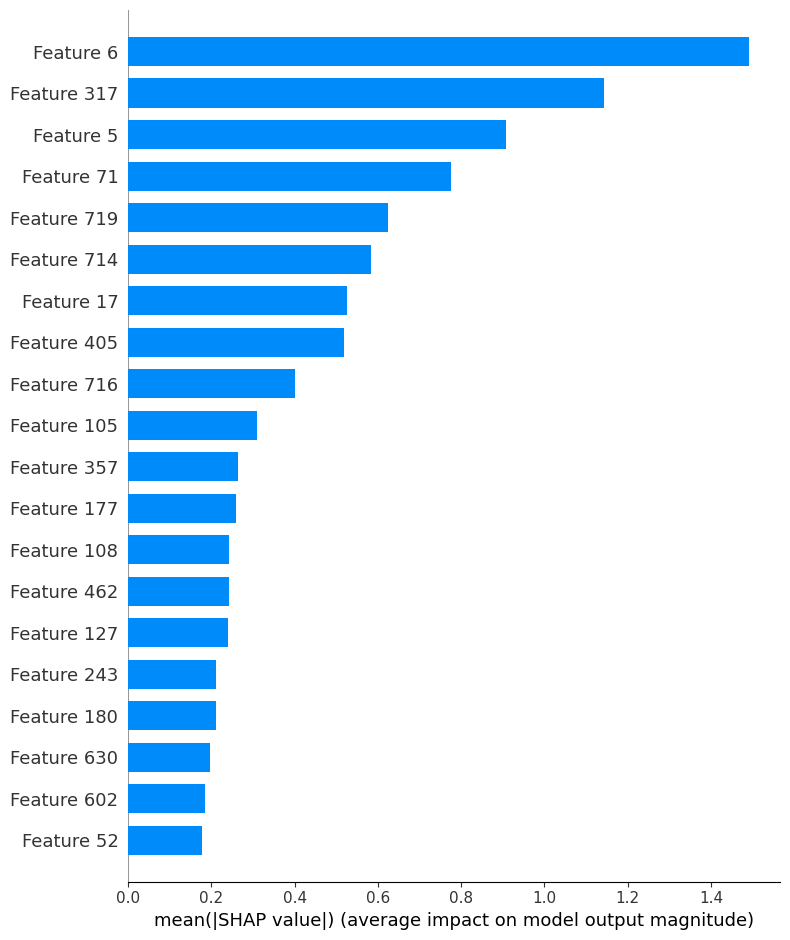

In [40]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

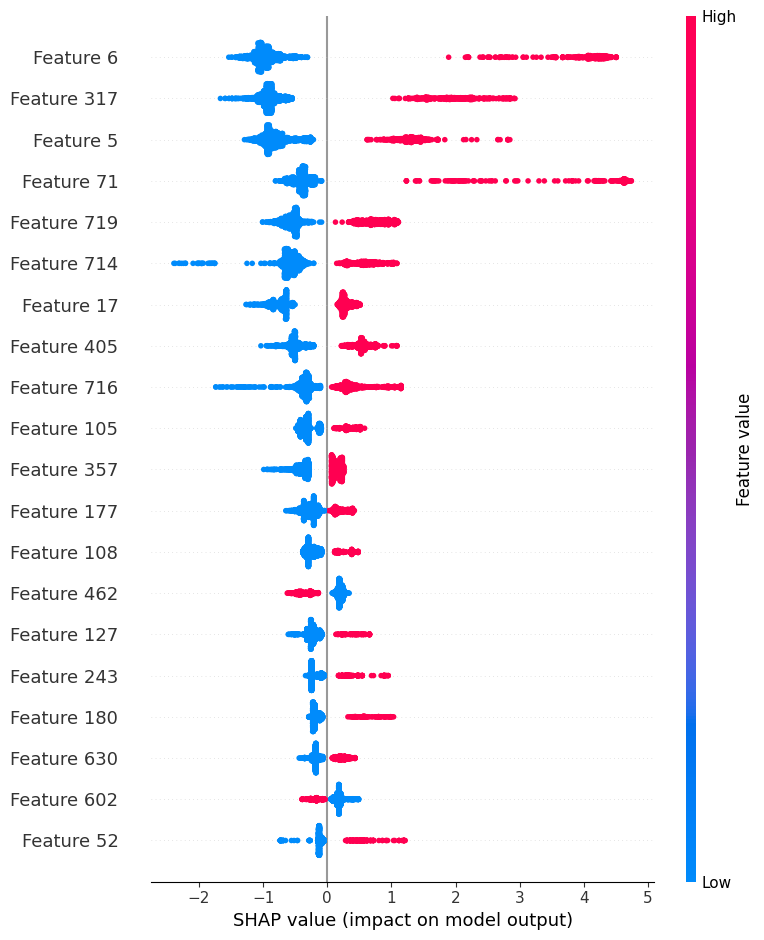

In [39]:
shap.summary_plot(shap_values, X_train)

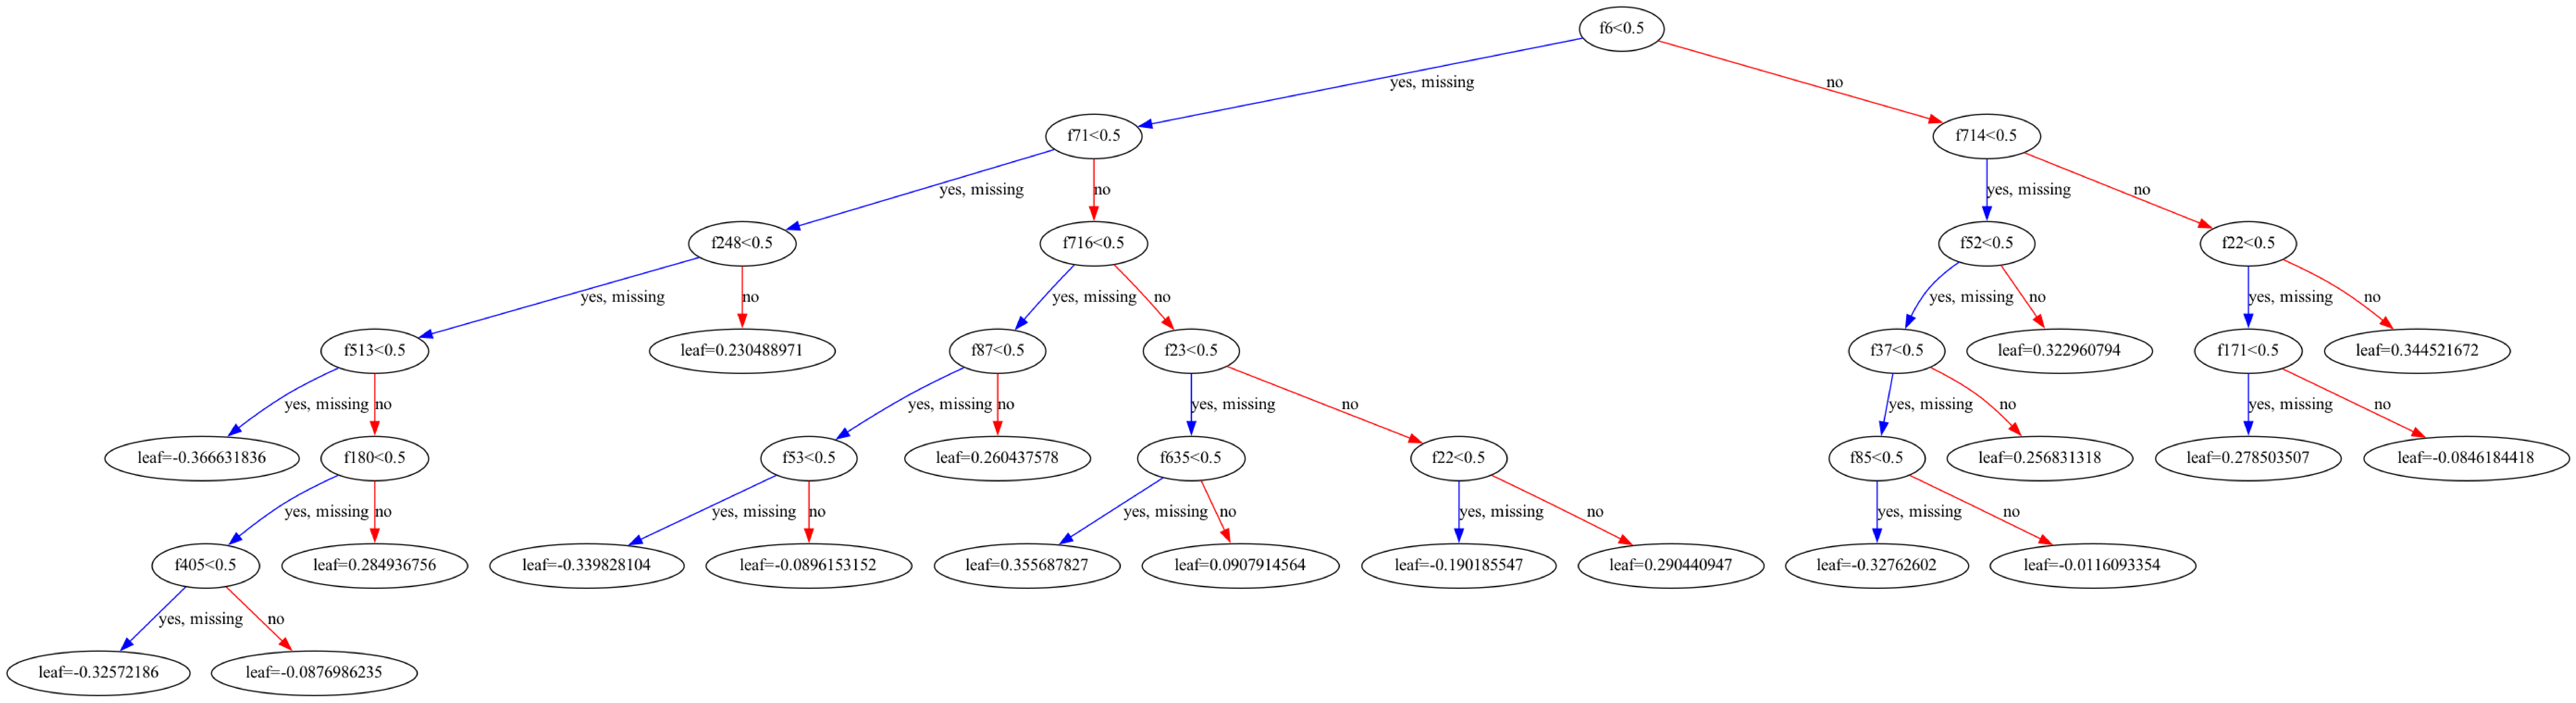

In [56]:
xgboost.plot_tree(model, num_trees=3)
fig = plt.gcf()
fig.set_size_inches(150, 200)
fig.savefig('tree.png')

In [ ]:
# Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(i) for i in top_fragments], molsPerRow=5, useSVG=True, maxMols=top_k)